 # My Capstone Project

### 1. Business Problem

<b>Background</b><br>
Nowadays there are a variety of choices, especially when it comes to real estate. I'm part of the DataScientists group of a Real Estate agency and I was requested to find the best apartment in Bucharest, Romania and to fit the criteria set by the client.<br>

His main requests are:
<ul>
    <li>to have 1 or 2 rooms</li>
    <li>to be in the range of the average price</li>
    <li>to be near the central zone</li>
    <li>to be near the subway</li>
    <li>to be in the area with most venues </li>
    <li>to have the price between 55.000 and 90.000</li>
</ul>

<b>Problem</b><br>
What is the best option of an apartment for a couple in Bucharest in 2021?


### 2. Data Requirements

<b>Sources</b>
<ul>
    <li><i>The Foursquare location data</i>- I will use the Foursquare location data to fill all the client's requested criteria about how the zone should be like</li>
    <li><i>Real Estate csv</i>- I will use a Real Estate csv found on kaggle with the prices and the locations of the apartments(from april 2021), which will give me the opportunity to search for an apartment that will suit my client the best <br>
    The columns of the csv are: location_area, price, rooms_count and subway_distance</li>
</ul>

In [1]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
file='house_sales_april_2021.csv'
df=pd.read_csv(file)
df.head()

id  updated_at                                location location_area  \
0   0  04.04.2021                 Bucuresti, zona Grivita       Grivita   
1   1  04.04.2021    Bucuresti, Sector 3, zona Vitan Mall    Vitan Mall   
2   2  04.04.2021  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol   
3   3  04.04.2021  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol   
4   4  04.04.2021               Bucuresti, zona Herastrau     Herastrau   

   subway_dist    partitioning comfort  furnished  heater_owner   price  \
0          579      decomandat       1          0             1   99000   
1          644      decomandat     lux          0             1  175000   
2          498      decomandat     lux          0             1  172000   
3          498      decomandat     lux          0             1  167000   
4         1564  semidecomandat     lux          0             1  235000   

   rooms_count  useful_surface  built_surface  construction_year  \
0            2            58.0           66.9             2021.0   
1            3            85.0           95.0             2021.0   
2            3           115.0          125.0             2019.0   
3            3           115.0          125.0             2019.0   
4            3            84.0           98.0             2019.0   

      real_estate_type height_regime level  max_level  kitchens_count  \
0  bloc de apartamente          P+4E     1        4.0             1.0   
1  bloc de apartamente          P+6E     5        6.0             1.0   
2  bloc de apartamente          P+7E     5        7.0             1.0   
3  bloc de apartamente          P+7E     2        7.0             1.0   
4  bloc de apartamente          P+7E     3        7.0             1.0   

   bathrooms_count  garages_count  parking_lots_count  balconies_count  
0              1.0            NaN                 NaN              1.0  
1              2.0            NaN                 NaN              1.0  
2              2.0            NaN                 NaN              1.0  
3              2.0            NaN                 NaN              1.0  
4              2.0            NaN                 1.0              1.0

In [3]:
#drop unneeded cols
df=df.filter(['location','location_area','subway_dist','price','real_estate_type','rooms_count'])
#change the row value with a more significant one
df['real_estate_type']=df['real_estate_type'].replace('bloc de apartamente','apartment')
#display only apartments
df=df[df['real_estate_type']=='apartment']
#Replace 'P-ta' with 'Piata'
df['location_area']=df['location_area'].replace('P-ta', 'Piata', regex=True)
df.head()

location location_area  subway_dist   price  \
0                 Bucuresti, zona Grivita       Grivita          579   99000   
1    Bucuresti, Sector 3, zona Vitan Mall    Vitan Mall          644  175000   
2  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  172000   
3  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  167000   
4               Bucuresti, zona Herastrau     Herastrau         1564  235000   

  real_estate_type  rooms_count  
0        apartment            2  
1        apartment            3  
2        apartment            3  
3        apartment            3  
4        apartment            3

In [11]:
#find the size of df
df.shape

(9774, 6)

In [13]:
#check the type of the columns
df.dtypes

location            object
location_area       object
subway_dist          int64
price                int64
real_estate_type    object
rooms_count          int64
dtype: object

In [4]:
def get_geocoder(location_area_df):  
    locator = Nominatim(user_agent="myGeocoder")
    g= locator.geocode('{}'.format(location_area_df))
    latitude = g.latitude
    longitude = g.longitude
    return latitude,longitude

In [5]:
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="myGeocoder")
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['locat'] = df['location_area'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['locat'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [6]:
df.head()

location location_area  subway_dist   price  \
0                 Bucuresti, zona Grivita       Grivita          579   99000   
1    Bucuresti, Sector 3, zona Vitan Mall    Vitan Mall          644  175000   
2  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  172000   
3  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  167000   
4               Bucuresti, zona Herastrau     Herastrau         1564  235000   

  real_estate_type  rooms_count  \
0        apartment            2   
1        apartment            3   
2        apartment            3   
3        apartment            3   
4        apartment            3   

                                               locat  \
0  (Grivița, Vaslui, 737280, România, (46.1614107...   
1  (București Mall, 55-59, Calea Vitan, Vitan, Se...   
2  (Parcul Carol, Sector 5, Municipiul București,...   
3  (Parcul Carol, Sector 5, Municipiul București,...   
4  (Herăstrău, Șoseaua București-Ploiești, Sector...   

                                          point   latitude  longitude  \
0                 (46.1614107, 27.6625747, 0.0)  46.161411  27.662575   
1         (44.4202621, 26.126687832266356, 0.0)  44.420262  26.126688   
2  (44.413852500000004, 26.09615693104473, 0.0)  44.413853  26.096157   
3  (44.413852500000004, 26.09615693104473, 0.0)  44.413853  26.096157   
4                 (44.4802978, 26.0791767, 0.0)  44.480298  26.079177   

   altitude  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [7]:
#drop unnecessary cols
df = df.drop(['locat', 'altitude', 'point'], axis=1)
#drop missing values
df=df.dropna(subset=['latitude', 'longitude','location_area'])
df.head()

location location_area  subway_dist   price  \
0                 Bucuresti, zona Grivita       Grivita          579   99000   
1    Bucuresti, Sector 3, zona Vitan Mall    Vitan Mall          644  175000   
2  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  172000   
3  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  167000   
4               Bucuresti, zona Herastrau     Herastrau         1564  235000   

  real_estate_type  rooms_count   latitude  longitude  
0        apartment            2  46.161411  27.662575  
1        apartment            3  44.420262  26.126688  
2        apartment            3  44.413853  26.096157  
3        apartment            3  44.413853  26.096157  
4        apartment            3  44.480298  26.079177

### Be near the subway

In [8]:
#The distance to the subway to be less than 900 m
df=df[df['subway_dist']<900]
df.head()

location location_area  subway_dist   price  \
0                 Bucuresti, zona Grivita       Grivita          579   99000   
1    Bucuresti, Sector 3, zona Vitan Mall    Vitan Mall          644  175000   
2  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  172000   
3  Bucuresti, Sector 4, zona Parcul Carol  Parcul Carol          498  167000   
5                 Bucuresti, zona Mosilor       Mosilor          776   79999   

  real_estate_type  rooms_count   latitude  longitude  
0        apartment            2  46.161411  27.662575  
1        apartment            3  44.420262  26.126688  
2        apartment            3  44.413853  26.096157  
3        apartment            3  44.413853  26.096157  
5        apartment            2  47.230328  28.856537

### Have 1 or 2 rooms

In [66]:
df=df[df['rooms_count'].isin([1,2])]

## Explore and cluster areas in Bucharest

In [62]:
# create map of Bucharest using latitude and longitude values
latitude=44.4330
longitude=26.1024
map_bucharest = folium.Map(location=[ latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, area in zip(df['latitude'], df['longitude'], df['location_area']):
    label = '{}'.format(area)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bucharest)  
    
map_bucharest

In [72]:
#create df with central areas
df=(df.loc[df['location_area'].isin(['Gara de Nord','Universitate','Armeneasca','Mosilor','Brezoianu','Natiunile Unite','Calea Calarasilor','Piata Unirii','Cismigiu','Batistei','Calea Victoriei','Matei Voevod','Pache Protopopescu'])])

In [73]:
df.head()

location      location_area  \
5                        Bucuresti, zona Mosilor            Mosilor   
77                      Bucuresti, zona Cismigiu           Cismigiu   
478                      Bucuresti, zona Mosilor            Mosilor   
825  Bucuresti, Sector 3, zona Calea Calarasilor  Calea Calarasilor   
858                 Bucuresti, zona Universitate       Universitate   

     subway_dist  price real_estate_type  rooms_count   latitude  longitude  
5            776  79999        apartment            2  47.230328  28.856537  
77           485  80000        apartment            1  44.437424  26.087402  
478          895  85996        apartment            2  47.230328  28.856537  
825          873  81000        apartment            1  45.254743  27.957209  
858          473  77000        apartment            2  44.435563  26.102468

### Get area with most venues

In [74]:
import requests
CLIENT_ID = 'AHEISVWQUZLRK0GIQ0AUMH1TQZBV1QIMGZDPBQZSKBVV2MHN' # your Foursquare ID
CLIENT_SECRET = 'CT4EE222ML5CHD1YBROZP2ZNGYQ1D3WJAQ2JLDTCWQYX2SU5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius= 500
latitude=df['latitude']
longitude=df['longitude']
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AHEISVWQUZLRK0GIQ0AUMH1TQZBV1QIMGZDPBQZSKBVV2MHN
CLIENT_SECRET:CT4EE222ML5CHD1YBROZP2ZNGYQ1D3WJAQ2JLDTCWQYX2SU5


In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
bucharest_venues = getNearbyVenues(names=df['location_area'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )
bucharest_venues

In [77]:
bucharest_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Cismigiu              44.437424               26.087402   
1     Cismigiu              44.437424               26.087402   
2     Cismigiu              44.437424               26.087402   
3     Cismigiu              44.437424               26.087402   
4     Cismigiu              44.437424               26.087402   

                      Venue  Venue Latitude  Venue Longitude  \
0              Hotel Epoque       44.436794        26.087105   
1          Burgeria Știrbei       44.439934        26.086442   
2          Grădina Cișmigiu       44.436734        26.091040   
3  Restaurant Libanez Tulin       44.439368        26.086887   
4                 Edo Sushi       44.439983        26.089853   

              Venue Category  
0                      Hotel  
1               Burger Joint  
2                       Park  
3  Middle Eastern Restaurant  
4           Sushi Restaurant

### Analyze the regions

In [187]:
# one hot encoding
buc_onehot = pd.get_dummies(bucharest_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
buc_onehot['Neighborhood'] = bucharest_venues['Neighborhood'] 

# move neighborhood column to the first column
list_column = buc_onehot.columns.tolist()
number_column = int(list_column.index('Neighborhood'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
buc_onehot = buc_onehot[list_column]

buc_onehot.head()

Neighborhood  American Restaurant  Art Gallery  Art Museum  Bagel Shop  \
0     Cismigiu                    0            0           0           0   
1     Cismigiu                    0            0           0           0   
2     Cismigiu                    0            0           0           0   
3     Cismigiu                    0            0           0           0   
4     Cismigiu                    0            0           0           0   

   Bakery  Bar  Beer Bar  Beer Garden  Bistro  Bookstore  Boutique  Brasserie  \
0       0    0         0            0       0          0         0          0   
1       0    0         0            0       0          0         0          0   
2       0    0         0            0       0          0         0          0   
3       0    0         0            0       0          0         0          0   
4       0    0         0            0       0          0         0          0   

   Breakfast Spot  Buffet  Burger Joint  Cafeteria  Café  Capitol Building  \
0               0       0             0          0     0                 0   
1               0       0             1          0     0                 0   
2               0       0             0          0     0                 0   
3               0       0             0          0     0                 0   
4               0       0             0          0     0                 0   

   Casino  Chinese Restaurant  Chocolate Shop  Church  Clothing Store  \
0       0                   0               0       0               0   
1       0                   0               0       0               0   
2       0                   0               0       0               0   
3       0                   0               0       0               0   
4       0                   0               0       0               0   

   Cocktail Bar  Coffee Shop  Cosmetics Shop  Cultural Center  Cupcake Shop  \
0             0            0               0                0             0   
1             0            0               0                0             0   
2             0            0               0                0             0   
3             0            0               0                0             0   
4             0            0               0                0             0   

   Dance Studio  Dessert Shop  Diner  Doner Restaurant  Drugstore  \
0             0             0      0                 0          0   
1             0             0      0                 0          0   
2             0             0      0                 0          0   
3             0             0      0                 0          0   
4             0             0      0                 0          0   

   Eastern European Restaurant  Electronics Store  Farmers Market  \
0                            0                  0               0   
1                            0                  0               0   
2                            0                  0               0   
3                            0                  0               0   
4                            0                  0               0   

   Fish & Chips Shop  Flower Shop  Food Truck  Fountain  French Restaurant  \
0                  0            0           0         0                  0   
1                  0            0           0         0                  0   
2                  0            0           0         0                  0   
3                  0            0           0         0                  0   
4                  0            0           0         0                  0   

   Fried Chicken Joint  Gaming Cafe  Garden  Gastropub  Gourmet Shop  \
0                    0            0       0          0             0   
1                    0            0       0          0             0   
2                    0            0       0          0             0   
3                    0            0       0          0             0   
4               

In [188]:
buc_grouped = buc_onehot.groupby('Neighborhood').mean().reset_index()
buc_grouped.head()

Neighborhood  American Restaurant  Art Gallery  Art Museum  \
0           Batistei             0.016393          0.0    0.000000   
1          Brezoianu             0.000000          0.0    0.000000   
2  Calea Calarasilor             0.000000          0.0    0.000000   
3    Calea Victoriei             0.000000          0.0    0.030303   
4           Cismigiu             0.000000          0.0    0.000000   

   Bagel Shop    Bakery      Bar  Beer Bar  Beer Garden    Bistro  Bookstore  \
0         0.0  0.016393  0.04918      0.00          0.0  0.000000       0.00   
1         0.0  0.020000  0.00000      0.02          0.0  0.020000       0.02   
2         0.0  0.000000  0.00000      0.00          0.0  0.000000       0.00   
3         0.0  0.030303  0.00000      0.00          0.0  0.030303       0.00   
4         0.0  0.000000  0.00000      0.00          0.0  0.000000       0.00   

   Boutique  Brasserie  Breakfast Spot    Buffet  Burger Joint  Cafeteria  \
0       0.0        0.0             0.0  0.000000      0.016393   0.016393   
1       0.0        0.0             0.0  0.000000      0.020000   0.000000   
2       0.0        0.0             0.0  0.000000      0.000000   0.000000   
3       0.0        0.0             0.0  0.030303      0.060606   0.000000   
4       0.0        0.0             0.0  0.000000      0.026316   0.000000   

       Café  Capitol Building  Casino  Chinese Restaurant  Chocolate Shop  \
0  0.081967               0.0     0.0            0.032787             0.0   
1  0.020000               0.0     0.0            0.000000             0.0   
2  0.000000               0.0     0.0            0.000000             0.0   
3  0.030303               0.0     0.0            0.030303             0.0   
4  0.210526               0.0     0.0            0.000000             0.0   

   Church  Clothing Store  Cocktail Bar  Coffee Shop  Cosmetics Shop  \
0    0.00             0.0      0.032787     0.032787             0.0   
1    0.02             0.0      0.020000     0.160000             0.0   
2    0.00             0.0      0.000000     0.000000             0.0   
3    0.00             0.0      0.000000     0.121212             0.0   
4    0.00             0.0      0.000000     0.078947             0.0   

   Cultural Center  Cupcake Shop  Dance Studio  Dessert Shop     Diner  \
0              0.0      0.016393           0.0      0.000000  0.000000   
1              0.0      0.000000           0.0      0.000000  0.000000   
2              0.0      0.000000           0.0      0.000000  0.000000   
3              0.0      0.000000           0.0      0.060606  0.030303   
4              0.0      0.000000           0.0      0.000000  0.000000   

   Doner Restaurant  Drugstore  Eastern European Restaurant  \
0               0.0        0.0                     0.016393   
1               0.0        0.0                     0.000000   
2               0.0        0.0                     0.000000   
3               0.0        0.0                     0.000000   
4               0.0        0.0                     0.000000   

   Electronics Store  Farmers Market  Fish & Chips Shop  Flower Shop  \
0               0.00             0.0               0.00     0.016393   
1               0.02             0.0               0.02     0.000000   
2               0.00             0.0               0.00     0.000000   
3               0.00             0.0               0.00     0.000000   
4               0.00             0.0               0.00     0.000000   

   Food Truck  Fountain  French Restaurant  Fried Chicken Joint  Gaming Cafe  \
0    0.000000       0.0           0.000000                  0.0     0.016393   
1    0.000000       0.0           0.000000                  0.0     0.000000   
2    0.000000       0.0           0.000000                  0.0     0.000000   
3    0.030303       0.0           0.060606                  0.0     0.000000   
4    0.000000       0.0           0.026316                  0.0     0.000000   

     Gard

### Cluster the neighborhoods

In [191]:
# set number of clusters
#I set the number 2 because it was the optimal variant given by the function
kclusters = 2

buc_grouped_clustering = buc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(buc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([0, 0, 1, 0, 0, 0, 0, 0, 0])

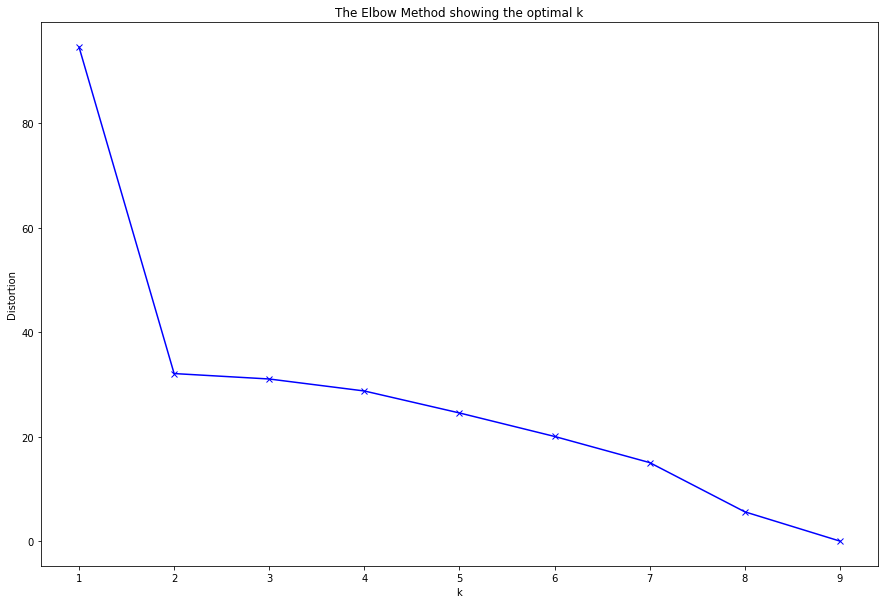

In [192]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(buc_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(buc_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / buc_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [88]:
#Vizualize the region with most venues
region=bucharest_venues.drop(['Neighborhood Latitude','Neighborhood Longitude', 'Venue Latitude','Venue Longitude','Venue Category'], axis=1)


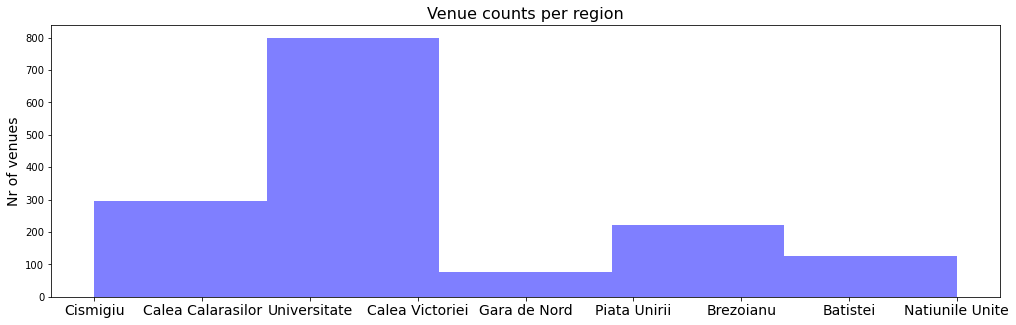

In [97]:
plt.rcParams['figure.figsize']=(17,5)
num_bins = 5
n, bins, patches = plt.hist(region['Neighborhood'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Venue counts per region",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Nr of venues', fontsize=14)
plt.show()

As we can see the most venues are at 'Universitate'

Let's explore the venues category for the selected region

In [100]:
df_grouped=bucharest_venues.copy()

In [156]:
df_ven=df_ven[df_ven['Neighborhood']=='Universitate']
#drop unnecessary cols
df_ven=df_ven.drop(['Neighborhood Latitude','Neighborhood Longitude','Neighborhood', 'Venue Latitude','Venue Longitude','Venue'], axis=1)
#count by category
df_ven['Counts'] = df_ven.groupby(['Venue Category'])['Venue Category'].transform('count')
#find top ten most popular categories
df_grouped=df_ven.groupby('Venue Category').sum().reset_index()
df_grouped=df_grouped.sort_values(by=['Counts'], ascending=False)
#set index as Venue category
df_grouped=df_grouped.set_index('Venue Category')
df_grouped=df_grouped.head(10)
df_grouped

Venue Category  Counts
15         Coffee Shop    3136
53             Theater    1764
29               Hotel     784
14      Clothing Store     784
39              Palace     441
31  Italian Restaurant     441

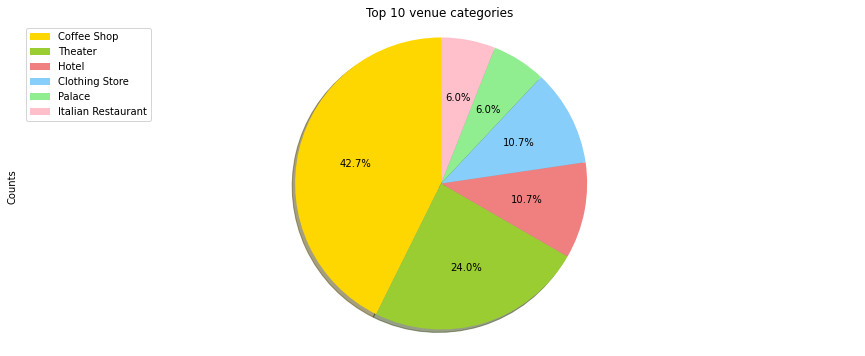

In [164]:
#Visualizing data with a pie chart
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink','orchid','firebrick','lavender','teal']
df_grouped['Counts'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            colors=colors_list,  # add custom colors
                            )

plt.title('Top 10 venue categories') 

plt.axis('equal') 

# add legend
plt.legend(labels=df_grouped.index, loc='upper left') 

plt.show()

### Have an average price

Find the prices within the range of 55.500 and 90.000

In [ ]:
#find apartments within this range
df=df[df['price'].between(55500, 90000)]

Examine the frequency of prices in Bucharest with a histogram

In [165]:
data_process = df.sort_values('price').reset_index(drop=True)
data_process = data_process.drop(['latitude', 'longitude','real_estate_type','rooms_count','location','subway_dist'], axis=1)
data_process.head()

location_area  price
0            Mosilor  57000
1  Calea Calarasilor  57500
2  Calea Calarasilor  59000
3    Natiunile Unite  60500
4           Cismigiu  66900

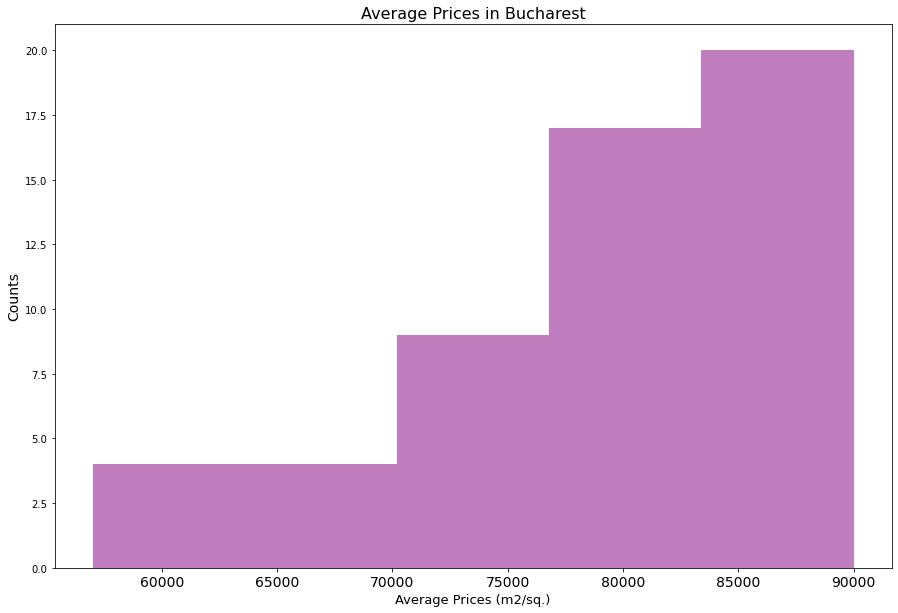

In [166]:
#Create a bigger graph
plt.rcParams['figure.figsize']=(15,10)
num_bins = 5
n, bins, patches = plt.hist(data_process['price'], num_bins, facecolor='purple', alpha=0.5)
plt.title("Average Prices in Bucharest",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Prices (m2/sq.)', fontsize=13)
plt.ylabel('Counts', fontsize=14)
plt.show()

In [167]:
#Find average price for every region
avg_price_region = data_process.groupby('location_area')['price'].agg(np.mean)

<AxesSubplot:xlabel='location_area'>

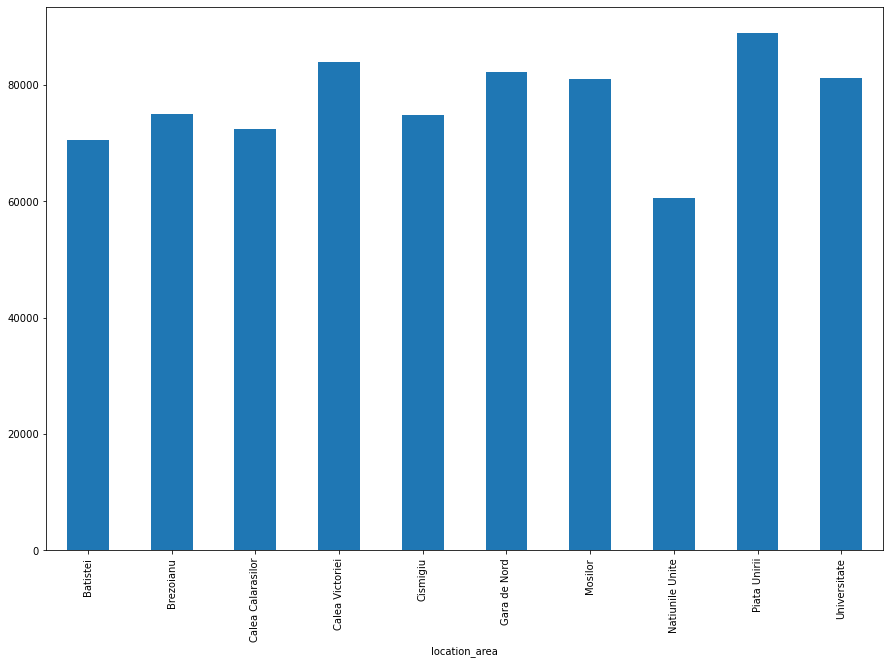

In [168]:
avg_price_region.plot.bar()

As we can see, the average price for our region- Universitate is around 80.000

### Cluster the selected area- Universitate

In [223]:
#Find top 10 venues at Universitate
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [224]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Neighborhood'] = buc_grouped['Neighborhood']

for ind in np.arange(buc_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(buc_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0           Batistei    Italian Restaurant                  Café   
1          Brezoianu           Coffee Shop               Theater   
2  Calea Calarasilor                 Hotel      Volleyball Court   
3    Calea Victoriei           Coffee Shop                 Hotel   
4           Cismigiu                  Café                 Hotel   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0                 Hotel                 Restaurant           Supermarket   
1                 Hotel                  Gastropub   Romanian Restaurant   
2            Restaurant                Pizza Place           Supermarket   
3    Italian Restaurant               Dessert Shop                Garden   
4           Coffee Shop  Middle Eastern Restaurant            Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Romanian Restaurant                   Pub                   Bar   
1            Restaurant      Greek Restaurant            Playground   
2              Fountain          Dessert Shop                 Diner   
3     French Restaurant          Burger Joint    Light Rail Station   
4      Sushi Restaurant    Spanish Restaurant                  Park   

  9th Most Common Venue 10th Most Common Venue  
0    Chinese Restaurant           Cocktail Bar  
1                Church      Fish & Chips Shop  
2      Doner Restaurant              Drugstore  
3      Greek Restaurant                    Spa  
4                 Plaza                    Pub

In [225]:
# add clustering labels
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

buc_merged = bucharest_venues

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
buc_merged = buc_merged.join(boroughs_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how ='inner')

buc_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Cismigiu              44.437424               26.087402   
1     Cismigiu              44.437424               26.087402   
2     Cismigiu              44.437424               26.087402   
3     Cismigiu              44.437424               26.087402   
4     Cismigiu              44.437424               26.087402   

                      Venue  Venue Latitude  Venue Longitude  \
0              Hotel Epoque       44.436794        26.087105   
1          Burgeria Știrbei       44.439934        26.086442   
2          Grădina Cișmigiu       44.436734        26.091040   
3  Restaurant Libanez Tulin       44.439368        26.086887   
4                 Edo Sushi       44.439983        26.089853   

              Venue Category 1st Most Common Venue 2nd Most Common Venue  \
0                      Hotel                  Café                 Hotel   
1               Burger Joint                  Café                 Hotel   
2                       Park                  Café                 Hotel   
3  Middle Eastern Restaurant                  Café                 Hotel   
4           Sushi Restaurant                  Café                 Hotel   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop  Middle Eastern Restaurant            Restaurant   
1           Coffee Shop  Middle Eastern Restaurant            Restaurant   
2           Coffee Shop  Middle Eastern Restaurant            Restaurant   
3           Coffee Shop  Middle Eastern Restaurant            Restaurant   
4           Coffee Shop  Middle Eastern Restaurant            Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Sushi Restaurant    Spanish Restaurant                  Park   
1      Sushi Restaurant    Spanish Restaurant                  Park   
2      Sushi Restaurant    Spanish Restaurant                  Park   
3      Sushi Restaurant    Spanish Restaurant                  Park   
4      Sushi Restaurant    Spanish Restaurant                  Park   

  9th Most Common Venue 10th Most Common Venue  
0                 Plaza                    Pub  
1                 Plaza                    Pub  
2                 Plaza                    Pub  
3                 Plaza                    Pub  
4                 Plaza                    Pub

In [226]:
univer_merged=buc_merged.copy()
univer_merged=univer_merged[univer_merged['Neighborhood']=='Universitate']
univer_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
43  Universitate              44.435563               26.102468   
44  Universitate              44.435563               26.102468   
45  Universitate              44.435563               26.102468   
46  Universitate              44.435563               26.102468   
47  Universitate              44.435563               26.102468   

                                 Venue  Venue Latitude  Venue Longitude  \
43  Teatrul Național "I. L. Caragiale"       44.436570        26.103638   
44                      Antic ExLibris       44.433489        26.102379   
45                 Piața Universității       44.435427        26.102308   
46                            Leonidas       44.433488        26.102255   
47                     iVy Coffee Shop       44.436263        26.105957   

    Venue Category 1st Most Common Venue 2nd Most Common Venue  \
43         Theater           Coffee Shop               Theater   
44  Used Bookstore           Coffee Shop               Theater   
45           Plaza           Coffee Shop               Theater   
46  Chocolate Shop           Coffee Shop               Theater   
47     Coffee Shop           Coffee Shop               Theater   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
43                 Hotel        Clothing Store         Historic Site   
44                 Hotel        Clothing Store         Historic Site   
45                 Hotel        Clothing Store         Historic Site   
46                 Hotel        Clothing Store         Historic Site   
47                 Hotel        Clothing Store         Historic Site   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
43                   Pub            Restaurant                Lounge   
44                   Pub            Restaurant                Lounge   
45                   Pub            Restaurant                Lounge   
46                   Pub            Restaurant                Lounge   
47                   Pub            Restaurant                Lounge   

   9th Most Common Venue 10th Most Common Venue  
43    Italian Restaurant              Bookstore  
44    Italian Restaurant              Bookstore  
45    Italian Restaurant              Bookstore  
46    Italian Restaurant              Bookstore  
47    Italian Restaurant              Bookstore

Create the map to see top venues in the selected area

In [ ]:
map_clusters = folium.Map(location=[neighborhood_latitude,neighborhood_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(univer_merged['Neighborhood Latitude'], univer_merged['Neighborhood Longitude'], univer_merged['Neighborhood'], univer_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster Labels ' + str(cluster),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Find the best price

In [276]:
df_result=df[df['location_area']=='Universitate']
df_result.reset_index(drop=True)

location location_area  subway_dist  price  \
0            Bucuresti, zona Universitate  Universitate          473  77000   
1            Bucuresti, zona Universitate  Universitate          522  81000   
2            Bucuresti, zona Universitate  Universitate          414  79000   
3            Bucuresti, zona Universitate  Universitate          465  77000   
4            Bucuresti, zona Universitate  Universitate          294  90000   
5            Bucuresti, zona Universitate  Universitate          410  85000   
6  Bucuresti, Sector 1, zona Universitate  Universitate          493  79000   

  real_estate_type  rooms_count   latitude  longitude  
0        apartment            2  44.435563  26.102468  
1        apartment            2  44.435563  26.102468  
2        apartment            2  44.435563  26.102468  
3        apartment            2  44.435563  26.102468  
4        apartment            1  44.435563  26.102468  
5        apartment            2  44.435563  26.102468  
6        apartment            2  44.435563  26.102468

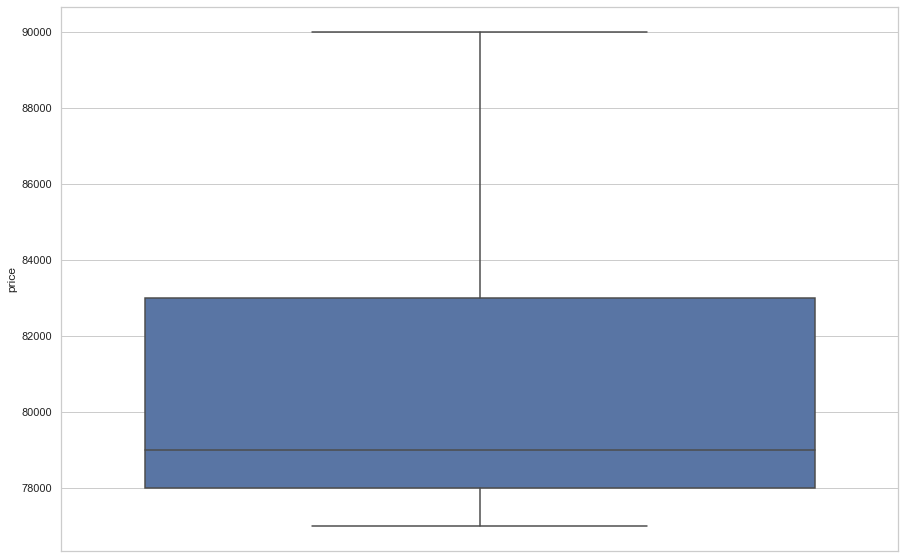

In [265]:
import seaborn as sns
ax = sns.boxplot(y="price", data=df_result)

In [280]:
#df_result=df_result.groupby('price')['subway_dist'].agg(np.mean)
#df_result=pd.DataFrame(df_result)
df_result.head(2)


subway_dist
price             
77000        469.0
79000        453.5
81000        522.0
85000        410.0
90000        294.0

As we can see the best price for an apartment in the selected neighborhood will have the price of 77.000 ron/sq2 and will be at a distance of 469 m from the subway

## Discussion

As seen in the analysis there are a variety of apartments on sale in Bucharest(9974 more exactly). With the great multitude of neighbourhoods, it takes time to analyze which variant would be the best. Moreover the analysis depends on the customer's needs, whatever he is looking for a family-friendly zone or for a fun zone for the youth. 

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 2. For more detailed and accurate guidance, the data set can be expanded and the features can be changed based on the custormer's need.

I also performed data analysis through this information and ploted/clustered the most important insights of this project

I ended the study by determining the best option of a neighborhood according to price, number of rooms, distance from subways and top venues in the zone

## Conclusion

As a result, this kind of data analysis would fit any type of customer: from business people who are looking for offices to families that decided to buy real estate

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.